In [3]:
import time

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

import numpy as np
from torchvision import datasets, models
import pandas as pd
import cv2
import os

from typing import Callable
import torch
import torch.optim
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, CenterCrop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
batch_size = 256
num_epochs = 3

optimizer_factory: Callable[
    [nn.Module], torch.optim.Optimizer
] = lambda model: torch.optim.Adam(model.parameters(), lr=0.001)

resize = (32,32)

transforms = Compose(
    [   
        ToTensor(),
        # CenterCrop((480, 640)),
        Resize(resize),
        # Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # RandomRotation(1),
        # ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),
        # Normalize(mean=[0.485, 0.456, 0.4], std=[0.229, 0.224, 0.2])
    ]
)

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None, device = "cpu"):
        self.df = pd.read_csv(csv_path)
        self.device = device
        self.images_folder = images_folder
        self.transform = transform
        self.img_tensor, self.label_tensor = self.load_data()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return (self.img_tensor[index], self.label_tensor[index])
    
    def load_data(self):
        # img_tensor = torch.zeros((len(self.df), num_channels, resize[0], resize[1])).to(self.device)
        # label_tensor = torch.zeros((len(self.df)))
        for i in range(len(self.df)):
            img_name = os.path.join(self.images_folder, self.df.iloc[i, 0])
            image = cv2.imread(img_name)
            label = int(self.df.iloc[i, -1])
            if self.transform:
                image = self.transform(image).to(self.device)
            if i==0:
                img_tensor = torch.unsqueeze(image, 0)
                label_tensor = [label]
                # print(label_tensor)
            else:
                img_tensor = torch.cat((img_tensor, torch.unsqueeze(image, 0)), 0)
                label_tensor.append(label)
            # print(img_tensor.shape)
        return img_tensor, torch.tensor(label_tensor).to(self.device)
    
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None, device = "cpu"):
        self.df = pd.read_csv(csv_path)
        self.device = device
        self.images_folder = images_folder
        self.transform = transform
        self.img_tensor = self.load_data()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.img_tensor[index]
    
    def load_data(self):
        for i in range(len(self.df)):
            img_name = os.path.join(self.images_folder, self.df.iloc[i, 0])
            image = cv2.imread(img_name)
            if self.transform:
                image = self.transform(image).to(self.device)
            if i==0:
                img_tensor = torch.unsqueeze(image, 0)
                # print(label_tensor)
            else:
                img_tensor = torch.cat((img_tensor, torch.unsqueeze(image, 0)), 0)
            # print(img_tensor.shape)
        return img_tensor

In [6]:
# Create the data loaders:
dataset = CustomDataset("./train.csv", "./images", transforms, "cuda")

/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:

test_loader = DataLoader(CustomTestDataset("./test.csv", "./images", transforms), 
    batch_size=batch_size, shuffle=True)
# train, val = torch.utils.data.random_split(dataset, [0.7, 0.3])
# train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
class Model(nn.Module):
    """
    A simple CNN with 2 convolutional layers and 2 fully-connected layers.
    """

    def __init__(self, num_channels: int, num_classes: int) -> None:
        super().__init__()
        # Input = 3 x 224 x 224, Output = 16 x 224 x 224
        self.conv_layer1 = nn.Conv2d(
            in_channels=num_channels,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        # Input = 16 x 224 x 224, Output = 16 x 224 x 224
        self.conv_layer2 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        # Input = 16 x 224 x 224, Output = 16, 112, 112
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input = 16, 112, 112, Output = 32, 112, 112
        self.conv_layer3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        # Input = 32, 112, 112, Output = 32, 112, 112
        self.conv_layer4 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        # Input = 32, 112, 112, Output = 32, 56, 56
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4096, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.soft = nn.Softmax()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        forward method
        """
        out = self.conv_layer1(x)
        # print(out.shape)
        out = self.relu1(out)
        out = self.conv_layer2(out)
        # print(out.shape)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.relu1(out)
        out = self.conv_layer4(out)
        
        out = self.relu1(out)
        out = self.max_pool2(out)
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        # out = nn.Dropout(0.25)(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        # print(out.shape)
        # out = self.soft(out)
        # print(out.shape)
        # exit()
        return out

In [9]:
# Create the model:
model = Model(num_channels=3, num_classes=2)
# Create the optimizer:
optimizer = optimizer_factory(model)
# Create the loss function:
criterion = torch.nn.CrossEntropyLoss()
# Train the model:
tic = time.time()
num_epochs = 50
num_channels = 3
train, val = torch.utils.data.random_split(dataset, [0.7, 0.3])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
# print(dataset.img_tensor.shape)
# print(dataset.label_tensor.shape)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:

import torch.nn as nn
import pretrainedmodels as pm
from sklearn.model_selection import KFold

model_ft = pm.__dict__["resnet50"](pretrained='imagenet')

model_ft.avg_pool = nn.AdaptiveAvgPool2d(1)
model_ft.last_linear = nn.Sequential(
    nn.BatchNorm1d(2048),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=2048, out_features=2048),
    nn.ReLU(),
    nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=2),
)

/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
def train_model(model, 
                data_loader, 
                dataset_size, 
                optimizer, 
                scheduler, 
                num_epochs):
    # criterion = nn.BCEWithLogitsLoss()
    criterion = torch.nn.CrossEntropyLoss()
    kfold = KFold(n_splits=10, shuffle=True)
    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        
        # Print
        print(f'FOLD {fold}')
        print('--------------------------------')
        
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        
        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=10, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=10, sampler=test_subsampler)
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            scheduler.step()
            model.train()

            running_loss = 0.0
            # Iterate over data.
            for bi, d in (train_loader):
                # inputs = d["image"]
                # labels = d["labels"]
                inputs = bi.to(device)
                labels = d.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / dataset_size
            print('train Loss: {:.4f}'.format(epoch_loss))

        running_loss = 0.0
        # Iterate over data.
        for bi, d in (val_loader):
            inputs = bi.to(device)
            labels = d.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / dataset_size
        print('val Loss: {:.4f}'.format(epoch_loss))
    return model

In [14]:
import torch.optim as optim
from torch.optim import lr_scheduler
model_ft = model_ft.to(device)
plist = [
        {'params': model_ft.layer4.parameters(), 'lr': 1e-5},
        {'params': model_ft.last_linear.parameters(), 'lr': 5e-3}
        ]
optimizer_ft = optim.Adam(plist, lr=0.001)
lr_sch = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)


model_ft = train_model(model_ft,
                       train_loader,
                       len(train_loader),
                       optimizer_ft,
                       lr_sch,
                       num_epochs=20)

torch.save(model_ft.state_dict(), "model.bin")

FOLD 0
--------------------------------
Epoch 0/19
----------
train Loss: 58.8321
Epoch 1/19
----------
train Loss: 57.7373
Epoch 2/19
----------
train Loss: 53.2738
Epoch 3/19
----------
train Loss: 50.1646
Epoch 4/19
----------
train Loss: 49.3968
Epoch 5/19
----------
train Loss: 46.4615
Epoch 6/19
----------
train Loss: 44.9536
Epoch 7/19
----------
train Loss: 43.8399
Epoch 8/19
----------
train Loss: 43.5864
Epoch 9/19
----------
train Loss: 32.0414
Epoch 10/19
----------
train Loss: 31.1812
Epoch 11/19
----------
train Loss: 29.7489
Epoch 12/19
----------
train Loss: 31.1069
Epoch 13/19
----------
train Loss: 28.5849
Epoch 14/19
----------
train Loss: 27.9795
Epoch 15/19
----------
train Loss: 27.2332
Epoch 16/19
----------
train Loss: 26.4577
Epoch 17/19
----------
train Loss: 27.1511
Epoch 18/19
----------
train Loss: 26.4698
Epoch 19/19
----------
train Loss: 26.0389
val Loss: 3.2846
FOLD 1
--------------------------------
Epoch 0/19
----------
train Loss: 25.4404
Epoch 1/19


KeyboardInterrupt: 

In [16]:
# Set the model to evaluation mode:
model_ft.eval()
device = "cpu"
# Compute the accuracy on the test data:
model_ft.to(device)
# Set the model to evaluation mode:
model_ft.eval()
# Initialize the number of correct predictions:
num_correct = 0
pred = np.array([])
# Loop over the data:
for x in tqdm(test_loader):
    # Move the data to the device:
    x = x.to(device)
    # Forward pass:
    y_hat = model_ft(x)
    # Compute the predictions:
    predictions = torch.argmax(y_hat, dim=1)
    pred = np.hstack((pred, predictions))

pred = pred.astype(int)
test_df = pd.read_csv("./test.csv")
img_path = test_df["img_path"]
df = pd.DataFrame()
df["has_under_extrusion"] = pred
df.insert(0, "img_path", img_path, True)
df.to_csv("submission.csv",index=False)

100%|██████████| 99/99 [01:13<00:00,  1.34it/s]


In [ ]:
# Move the model to the device:
model.to(device)
train_loss_list, val_loss_list = [], []
train_acc, validation_acc = [], []
# Loop over the epochs:
for epoch in tqdm(range(num_epochs)):
    device = "cuda"
    model.to(device)
    train_loss = 0.0
    # Set the model to training mode:
    model.train()
    # Loop over the training data:
    for x, y in train_loader:
        # Move the data to the device:
        x, y = x.to(device), y.to(device)
        # Zero the gradients:
        optimizer.zero_grad()
        # Forward pass:
        y_hat = model(x)
        # Compute the loss:
        loss = criterion(y_hat, y)
        # Backward pass:
        loss.backward()
        # Update the parameters:
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
    train_loss_list.append(train_loss)

    device = "cpu"
    model.to(device)
    valid_loss = 0.0
    # Set the model to evaluation mode:
    model.eval()
    # Initialize the number of correct predictions:
    num_correct = 0
    total = 0
    pred = np.array([])
    # Loop over the data:
    for x, y in val_loader:
        # Move the data to the device:
        x, y = x.to(device), y.to(device)
        # Forward pass:
        y_hat = model(x)
        # Compute the predictions:
        predictions = torch.argmax(y_hat, dim=1)
        pred = np.hstack((pred, predictions.cpu()))
        loss = criterion(y_hat,y)
        valid_loss += loss.item()
        num_correct += (predictions == y).float().sum().item()
        total += len(predictions)
    val_loss_list.append(valid_loss)
    if epoch%100 == 0:
        print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        print("acc : ", num_correct/total)
    validation_acc.append(num_correct/total)
    
        

In [ ]:
print(predictions[:10])
print(y[:10])

tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 1])
tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 1])


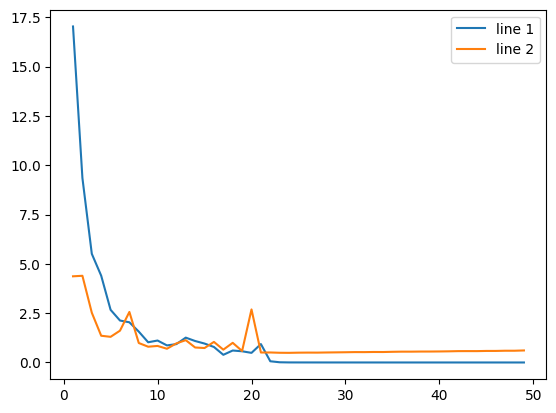

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(num_epochs)
# plot lines
plt.plot(epochs[1:], train_loss_list[1:], label = "line 1")
plt.plot(epochs[1:], val_loss_list[1:], label = "line 2")
# plt.plot(epochs, validation_acc, label = "line 3")
plt.legend()
plt.show()

In [ ]:
toc = time.time()
print(
    f"Training time: {toc - tic:.2f} seconds"
)
print(
    f"Training time: {(toc - tic)/60:.2f} mins"
)

Training time: 1309.28 seconds
Training time: 21.82 mins


In [ ]:
# Set the model to evaluation mode:
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cpu"
# Compute the accuracy on the test data:
model.to(device)
# Set the model to evaluation mode:
model.eval()
# Initialize the number of correct predictions:
num_correct = 0
pred = np.array([])
# Loop over the data:
for x in tqdm(test_loader):
    # Move the data to the device:
    x = x.to(device)
    # Forward pass:
    y_hat = model(x)
    # Compute the predictions:
    predictions = torch.argmax(y_hat, dim=1)
    pred = np.hstack((pred, predictions))

pred = pred.astype(int)
test_df = pd.read_csv("./test.csv")
img_path = test_df["img_path"]
df = pd.DataFrame()
df["has_under_extrusion"] = pred
df.insert(0, "img_path", img_path, True)
df.to_csv("submission.csv",index=False)

100%|██████████| 99/99 [00:08<00:00, 11.65it/s]


In [ ]:
# model_names = [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
import copy
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model.to("cpu")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print(dataloaders)
            print(phase)
            for inputs, labels in tqdm(dataloaders[phase]):
                print("inside")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 32

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 32

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /home/singroa/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:04<00:00, 114MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
train, val = torch.utils.data.random_split(dataset, [0.7, 0.3])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=4)
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = val_loader

NameError: name 'torch' is not defined

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
device = "cpu"
# Train and evaluate
model_ft, hist = train_model(model_ft.to(device), dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f79beefa2b0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f79bc0b8b50>}
train


  0%|          | 0/7093 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torch/utils/data/dataset.py", line 298, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/tmp/ipykernel_24462/2102966010.py", line 13, in __getitem__
    return (self.img_tensor[index], self.label_tensor[index])
RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

